In [ ]:
# Libraries
from pathlib import Path
from matplotlib import pyplot as plt
from boutdata import collect
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce
from typing import *
import matplotlib
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from collections import defaultdict
sns.set_style("whitegrid")

In [2]:
# Load and plot data

# Absolute path to either the BOUT output directory or an individual BOUT.dmp file.
DATA_LOCATION = Path(
	r"data/BOUT.dmp.0.nc"
 )


def load_density(path_hint: Path):
	"""Return the density field collected from BOUT output files."""
	path_hint = path_hint.expanduser().resolve()

	# If the user points at a single file we only need the parent directory.
	bout_dir = path_hint.parent if path_hint.is_file() else path_hint

	data = collect("n", path=str(bout_dir))
	return data.squeeze()


def plot_timestep(density,idx,vert=(False, None)):
	"""Plot the density at the final time step."""
	fig, ax = plt.subplots()
	contour = ax.contourf(density[idx, :, :].T)
	fig.colorbar(contour, ax=ax, label="n (arb. units)")
	ax.set_title("Density at final timestep")
	ax.set_xlabel("x index")
	ax.set_ylabel("z index")
	if vert[0] == True:
		ax.vlines(vert[1], 0, 1023)
	plt.show()

dens_data = load_density(DATA_LOCATION)


mxsub = 8 mysub = 1 mz = 1024

nxpe = 128, nype = 1, npes = 128

Reading from 0: [0-9][0-0] -> [0-9][0-0]

Reading from 1: [2-9][0-0] -> [10-17][0-0]

Reading from 2: [2-9][0-0] -> [18-25][0-0]

Reading from 3: [2-9][0-0] -> [26-33][0-0]

Reading from 4: [2-9][0-0] -> [34-41][0-0]

Reading from 5: [2-9][0-0] -> [42-49][0-0]

Reading from 6: [2-9][0-0] -> [50-57][0-0]

Reading from 7: [2-9][0-0] -> [58-65][0-0]

Reading from 8: [2-9][0-0] -> [66-73][0-0]

Reading from 9: [2-9][0-0] -> [74-81][0-0]

Reading from 10: [2-9][0-0] -> [82-89][0-0]

Reading from 11: [2-9][0-0] -> [90-97][0-0]

Reading from 12: [2-9][0-0] -> [98-105][0-0]

Reading from 13: [2-9][0-0] -> [106-113][0-0]

Reading from 14: [2-9][0-0] -> [114-121][0-0]

Reading from 15: [2-9][0-0] -> [122-129][0-0]

Reading from 16: [2-9][0-0] -> [130-137][0-0]

Reading from 17: [2-9][0-0] -> [138-145][0-0]

Reading from 18: [2-9][0-0] -> [146-153][0-0]

Reading from 19: [2-9][0-0] -> [154-161][0-0]

Reading from 20: [2-9][0-0] -> [

### Data Info

- 128 images of the nHESEL simulation
- Width = 1024, Height = 1028

In [3]:
import sys
import io
old_stdout = sys.stdout
sys.stdout = io.StringIO()
normalization_const = collect("n0", path=str(DATA_LOCATION.parent))
sys.stdout = old_stdout

In [4]:
print(dens_data.shape)
max_val = float(dens_data.max())
print(type(max_val))
print(f"Normalization const: {normalization_const}")
print(f"Maximum val in dataset: {max_val}")
# We normalize the whole dataset

density_data = dens_data / max_val

# What are the shapes?
density_data.shape
print(density_data.min())
print(density_data.max())



(93, 1028, 1024)
<class 'float'>
Normalization const: 5e+19
Maximum val in dataset: 1.204702195357749
0.00043175960220986144
1.0


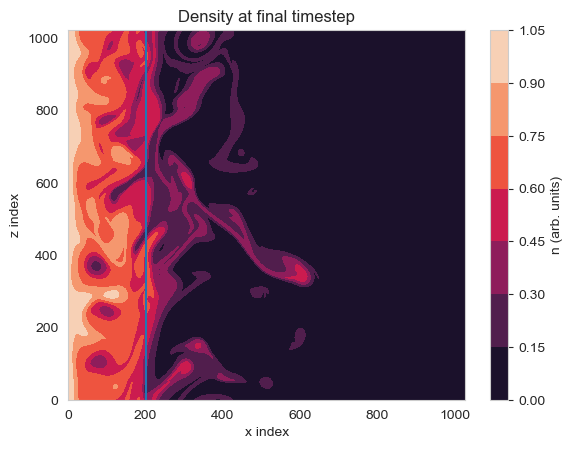

In [5]:
plot_timestep(density_data, idx=89, vert=(True, 200))

# It seems to be fitting to have the edge of the man plasma at x = 200

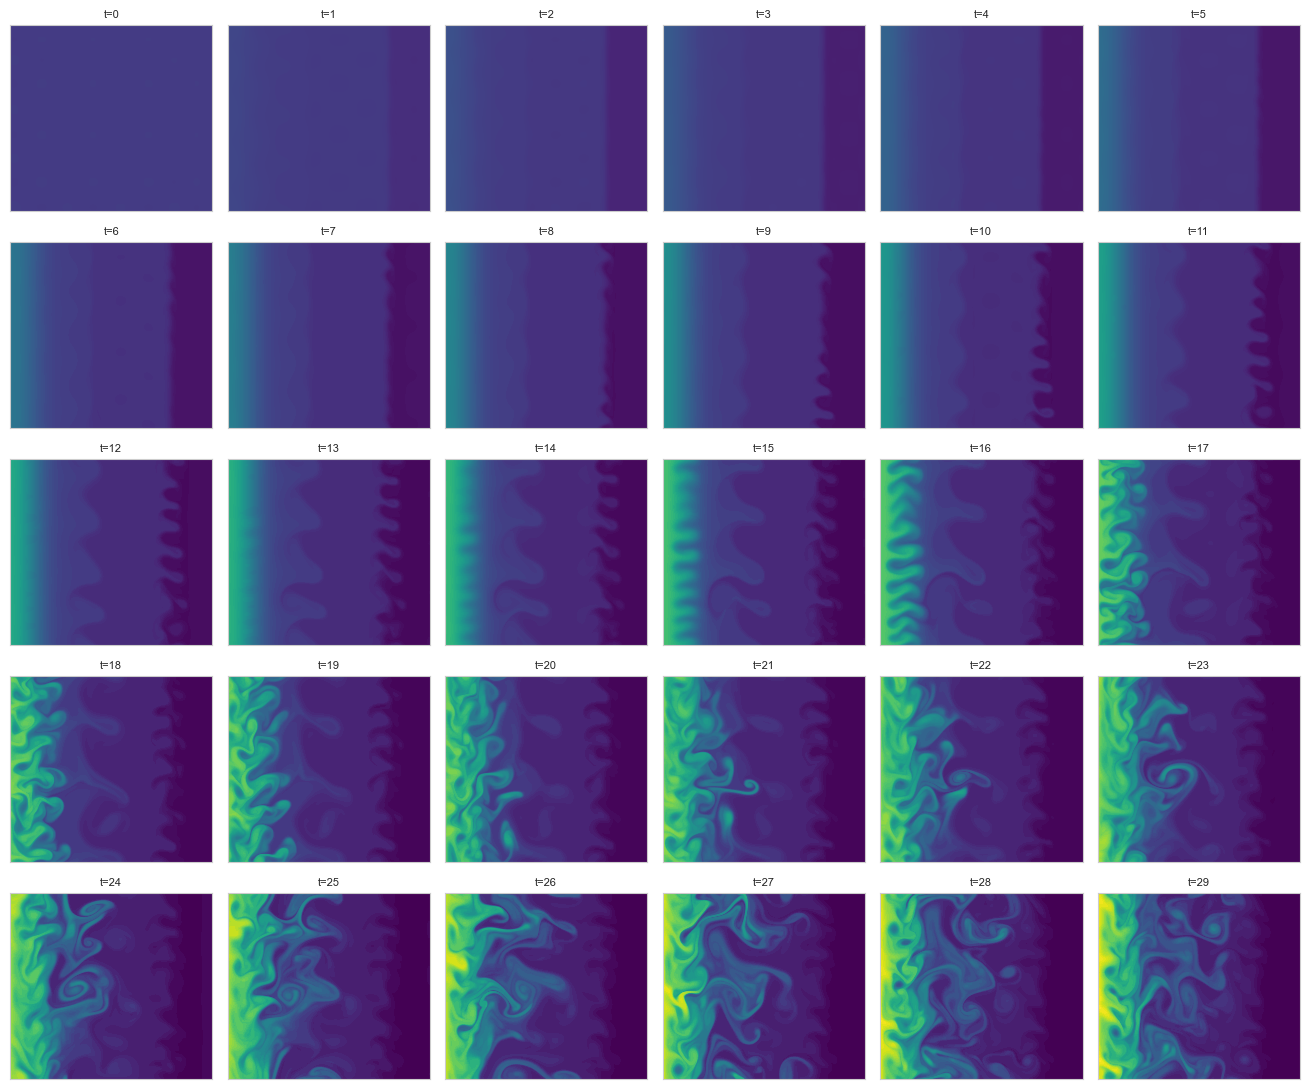

In [6]:
# Plot first 30 timesteps in a 5x6 grid
import numpy as np

n_plots = 30
rows, cols = 5, 6

# Use the loaded density data
data = density_data

# Compute consistent color scale across all frames
vmin = float(np.min(data[:n_plots]))
vmax = float(np.max(data[:n_plots]))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
for idx, ax in enumerate(axes.flat):
    im = ax.contourf(data[idx, :, :].T, levels=50, vmin=vmin, vmax=vmax, cmap="viridis")
    ax.set_title(f"t={idx}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Single colorbar for the whole figure
plt.tight_layout()
plt.show()

# The simulation first seems to have converged at approximately 28 steps into the simulation


As one can see above, convergence first happens after some timesteps. An appropriate timestep for convergence would be $t = 23$

In [7]:
from torch.utils.data import TensorDataset, DataLoader, random_split
selected_data = density_data[23:] # assuming convergence at t = 22
data_tensor = torch.tensor(selected_data, dtype=torch.float32)
data = data_tensor.unsqueeze(1) # It needs 1 channel
print(data.shape) # Ensure data shape matches expectation!

# train and validation size is 35
train_size = 35
test_size = 35

train_dataset, test_dataset = random_split(data, [train_size, test_size])

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([70, 1, 1028, 1024])


## VAE

In [8]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        epsilon = self.sample_epsilon()
        return self.mu + self.sigma * epsilon
            
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -0.5 * (math.log(2 * math.pi) + 2 * torch.log(self.sigma) + ((z - self.mu) ** 2) / (self.sigma ** 2))




In [19]:
# Making a logistic distribution now

class Logistic(Distribution):
    arg_constraints = {}
    support = torch.distributions.constraints.real
    has_rsample = True

    def __init__(self, loc, scale, validate_args=False):
        self.loc = loc
        self.scale = scale
        super().__init__(validate_args=validate_args)

    def rsample(self, sample_shape=torch.Size()):
        eps = torch.rand(sample_shape + self.loc.shape, device=self.loc.device)
        return self.loc + self.scale * torch.log(eps / (1 - eps))

    def log_prob(self, x):
        z = (x - self.loc) / self.scale
        return -z - torch.log(self.scale) - 2 * torch.log1p(torch.exp(-z))

In [20]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    
    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class ConvolutionalVariationalAutoencoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features: int, in_channels: int = 1) -> None:
        super().__init__()
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.in_channels = in_channels
        
        # Convolutional encoder keeps the code compact while extracting spatial features.
        self.conv_encoder = nn.Sequential(
            # PrintSize(),
            nn.Conv2d(in_channels, 32, kernel_size=128, stride=4, padding=(0,2)), # Output 226x226
            # PrintSize(),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=30, stride=6, padding=1), # Output dim: 34x34
            # PrintSize(),
            nn.ReLU(),
            nn.Dropout(),
            nn.Flatten(),
            # PrintSize(),
            nn.ReLU(),
            nn.Linear(16*34*34,256),
            nn.Flatten(),
            # PrintSize(),
            nn.ReLU(),
            nn.Linear(256,latent_features*2) # Notice that we multiply with 2 (sigma, mu)
        )
                
                
        self.conv_decoder = nn.Sequential(
            nn.Linear(latent_features, 256),
            nn.ReLU(),
            nn.Linear(256, 34*34*16),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(16, 34, 34)),
            nn.ConvTranspose2d(in_channels=16, 
                               out_channels=32, 
                               kernel_size=30,
                               stride=6,
                               padding=1,
            ),
            nn.ReLU(),
            # PrintSize(),
            nn.ConvTranspose2d(in_channels=32,
                               out_channels=in_channels,
                               kernel_size=128,
                               stride=4,
                               padding=(0, 2)
            ),
            # PrintSize()
        )
        
        # Prior parameters stay identical to the dense version.
        self.register_buffer("prior_params", torch.zeros(1, 2 * latent_features))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.conv_encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    # def observation_model(self, z:Tensor) -> Distribution:
    #     """return the distribution `p(x|z)`"""
    #     px_logits = self.conv_decoder(z)
    #     #px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
    #     return Bernoulli(logits=px_logits, validate_args=False)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        mu = self.conv_decoder(z)
        scale = 0.1 # Fixed standard deviation #TODO. look at this
        return torch.distributions.Normal(mu, scale)
        
    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
        
    def sample_from_prior(self, batch_size: int = 16) -> Dict[str, Any]:
        pz = self.prior(batch_size=batch_size)
        z = pz.rsample()
        px = self.observation_model(z)
        return {"px": px, "pz": pz, "z": z}


latent_features = 2
# Example usage once you have tensors shaped as (batch, 1, H, W):

In [21]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [22]:
print(density_data[22,:,:].shape)
test = torch.tensor(density_data[22,:,:], dtype=torch.float32)
print(test.shape)
test = test.unsqueeze(0).unsqueeze(0)
print(test.shape)

(1028, 1024)
torch.Size([1028, 1024])
torch.Size([1, 1, 1028, 1024])


In [23]:
# Testing if valid dimensions in Convolutional VAE
dummy_tensor = test
#dummy_tensor = torch.tensor(density_data[0,:,:,:].reshape(1,1028,1024), dtype=torch.float32)
C_VAE = ConvolutionalVariationalAutoencoder(dummy_tensor.shape, latent_features)
# Going manually through the the forward() method

# define the posterior q(z|x) / encode x into q(z|x)
qz = C_VAE.posterior(dummy_tensor)

# define the prior p(z)
pz = C_VAE.prior(batch_size=dummy_tensor.size(0))

# sample the posterior using the reparameterization trick: z ~ q(z | x)
z = qz.rsample()

# define the observation model p(x|z) = B(x | g(z))
px = C_VAE.observation_model(z)

print(px)

Normal(loc: torch.Size([1, 1, 1028, 1024]), scale: torch.Size([1, 1, 1028, 1024]))


In [24]:
images = test

vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(C_VAE, images)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean = -425852.219, shape: []
elbo   | mean = 425852.219, shape: [1]
log_px | mean = 425852.125, shape: [1]
kl     | mean =     -0.108, shape: [1]


In [25]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 16
cvae = ConvolutionalVariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 0.75
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

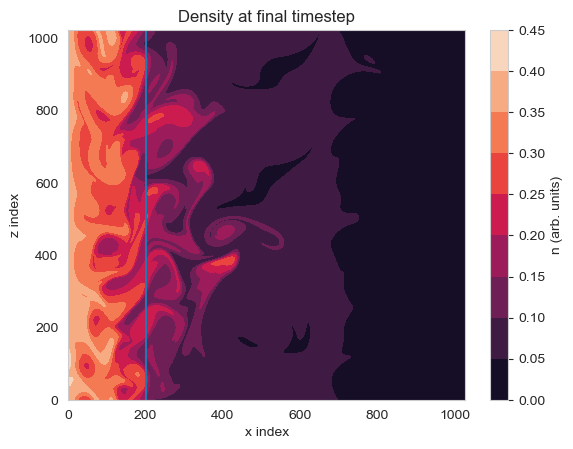

-0.02934182
0.045719467


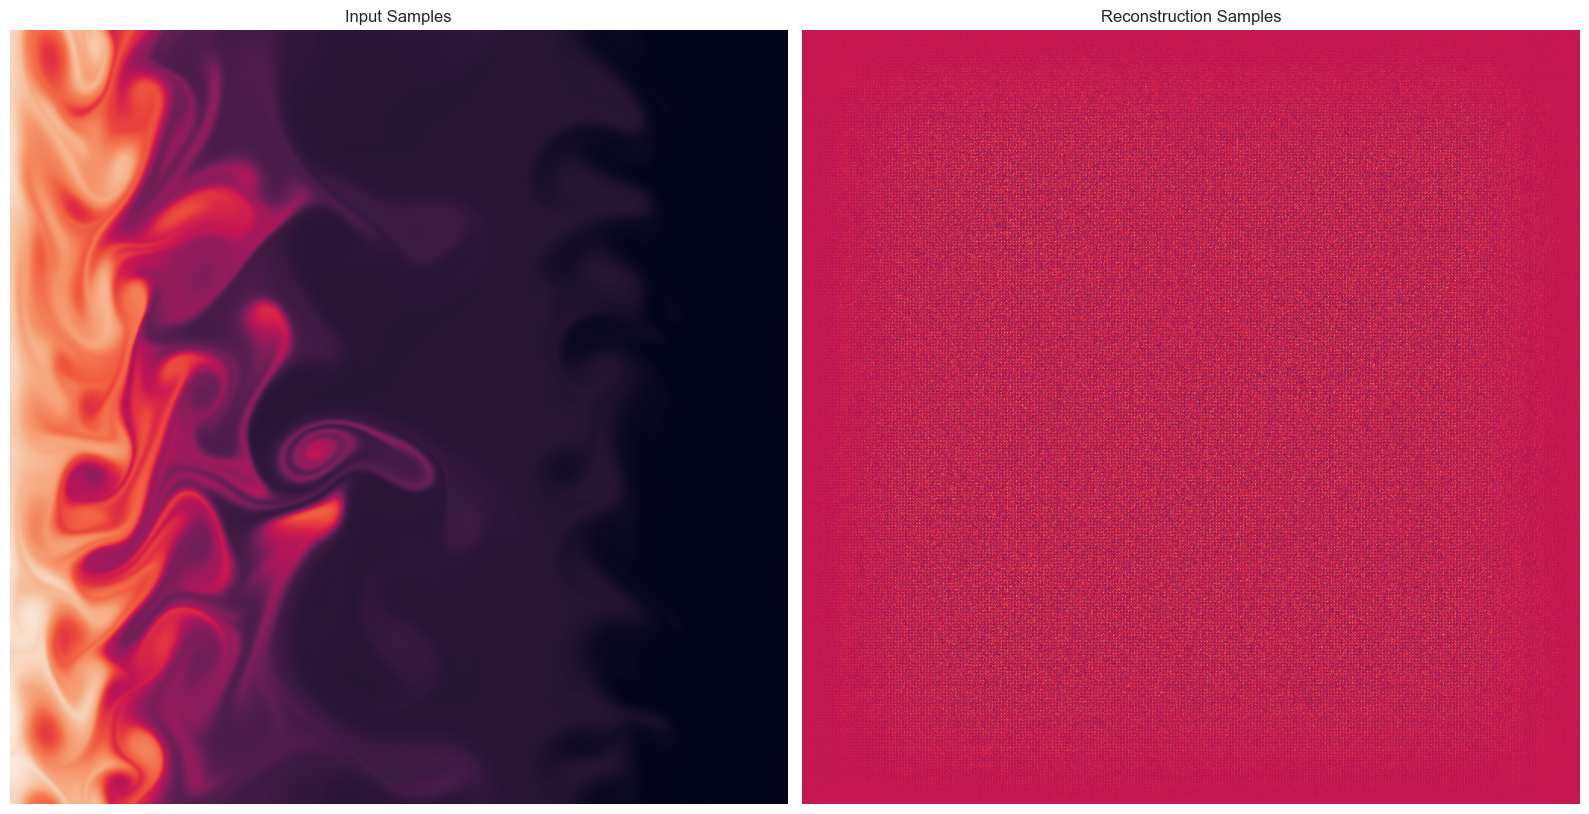

In [ ]:
from plotting import make_plasma_vae_plots
from torchvision.utils import make_grid



# Try plotting the dummy data

"""Plot the density at the final time step."""
fig, ax = plt.subplots()
contour = ax.contourf(dummy_tensor[0, 0, :, :].T)
fig.colorbar(contour, ax=ax, label="n (arb. units)")
ax.set_title("Density at final timestep")
ax.set_xlabel("x index")
ax.set_ylabel("z index")
ax.vlines(200, 0, 1023)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(16,14))
# --------------------
# Input (left)
# --------------------
axes[0].set_title("Input Samples")
x_input = dummy_tensor  # [B, C, H, W]

# Make sure it's a NumPy array for slicing
img = x_input[0, 0].cpu().numpy().T[::-1, :]  # transpose + flip horizontally
axes[0].imshow(img, cmap='rocket')
axes[0].axis("off")

# --------------------
# Reconstruction (right)
# --------------------

axes[1].set_title("Reconstruction Samples")
# x_hat_sample = px.sample().squeeze(2)  # [B, C, H, W]
# img_hat = px.probs[0,0].cpu().detach().numpy().T[::-1, :]
img_hat = px.mean[0, 0].cpu().detach().numpy().T[::-1, :]
# img_hat = x_hat_sample[0, 0, :, :].cpu().numpy().T[::-1, :]
axes[1].imshow(img_hat, cmap='rocket')
axes[1].axis("off")


plt.tight_layout()
plt.show()

# make_plasma_vae_plots(C_VAE, px, outputs, training_data, validation_data)

### Training and Evaluation

In [29]:
from collections import defaultdict
from plotting import make_plasma_vae_plots
# define the models, evaluator and optimizer

# CVAE
latent_features = 26
cvae = ConvolutionalVariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 0.75 # Might change
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)



In [30]:
num_epochs = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
cvae = cvae.to(device)

# training..
epoch = 0
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    cvae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(cvae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    print("Training finished") # TODO: remove this        

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    print("Data gathered") # TODO: remove this

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        cvae.eval()
        
        # Just load a single batch from the test loader
        x = next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(cvae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    print(f"{epoch} iterations completed")
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    make_plasma_vae_plots(cvae, x, outputs, training_data, validation_data)

>> Using device: cpu


ValueError: Expected parameter loc (Tensor of shape (1, 1, 1028, 1024)) of distribution Normal(loc: torch.Size([1, 1, 1028, 1024]), scale: torch.Size([1, 1, 1028, 1024])) to satisfy the constraint Real(), but found invalid values:
tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]],
       grad_fn=<ConvolutionBackward0>)